# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 977us/sample - loss: 255.1052 - y1_output_loss: 118.3707 - y2_output_loss: 134.5033 - y1_output_root_mean_squared_error: 10.9318 - y2_output_root_mean_squared_error: 11.6448 - val_loss: 104.0414 - val_y1_output_loss: 34.8053 - val_y2_output_loss: 68.1944 - val_y1_output_root_mean_squared_error: 5.9575 - val_y2_output_root_mean_squared_error: 8.2795
Epoch 2/500
614/614 [==============================] - 0s 155us/sample - loss: 33.8879 - y1_output_loss: 13.4509 - y2_output_loss: 20.7187 - y1_output_root_mean_squared_error: 3.6363 - y2_output_root_mean_squared_error: 4.5459 - val_loss: 21.4441 - val_y1_output_loss: 9.2458 - val_y2_output_loss: 11.5999 - val_y1_output_root_mean_squared_error: 3.0880 - val_y2_output_root_mean_squared_error: 3.4508
Epoch 3/500
614/614 [==============================] - 0s 140us/sample - loss: 24.5353 - y1_output_loss: 10.0220 - y2_output_loss: 14.7094 - y1

614/614 [==============================] - 0s 136us/sample - loss: 8.0184 - y1_output_loss: 2.5729 - y2_output_loss: 5.4217 - y1_output_root_mean_squared_error: 1.6076 - y2_output_root_mean_squared_error: 2.3311 - val_loss: 8.4414 - val_y1_output_loss: 2.9545 - val_y2_output_loss: 5.4559 - val_y1_output_root_mean_squared_error: 1.7400 - val_y2_output_root_mean_squared_error: 2.3268
Epoch 42/500
614/614 [==============================] - 0s 134us/sample - loss: 10.4324 - y1_output_loss: 3.1477 - y2_output_loss: 7.2352 - y1_output_root_mean_squared_error: 1.7765 - y2_output_root_mean_squared_error: 2.6975 - val_loss: 7.2540 - val_y1_output_loss: 2.5938 - val_y2_output_loss: 4.7689 - val_y1_output_root_mean_squared_error: 1.6205 - val_y2_output_root_mean_squared_error: 2.1513
Epoch 43/500
614/614 [==============================] - 0s 132us/sample - loss: 6.9684 - y1_output_loss: 2.1364 - y2_output_loss: 4.8013 - y1_output_root_mean_squared_error: 1.4672 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 134us/sample - loss: 5.2186 - y1_output_loss: 1.4468 - y2_output_loss: 3.7796 - y1_output_root_mean_squared_error: 1.1974 - y2_output_root_mean_squared_error: 1.9455 - val_loss: 4.6831 - val_y1_output_loss: 1.7266 - val_y2_output_loss: 3.0446 - val_y1_output_root_mean_squared_error: 1.3292 - val_y2_output_root_mean_squared_error: 1.7077
Epoch 63/500
614/614 [==============================] - 0s 137us/sample - loss: 5.7434 - y1_output_loss: 1.5682 - y2_output_loss: 4.1442 - y1_output_root_mean_squared_error: 1.2541 - y2_output_root_mean_squared_error: 2.0422 - val_loss: 8.4675 - val_y1_output_loss: 3.2036 - val_y2_output_loss: 5.0469 - val_y1_output_root_mean_squared_error: 1.8216 - val_y2_output_root_mean_squared_error: 2.2692
Epoch 64/500
614/614 [==============================] - 0s 132us/sample - loss: 4.5679 - y1_output_loss: 1.2478 - y2_output_loss: 3.3044 - y1_output_root_mean_squared_error: 1.1098 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 130us/sample - loss: 3.1688 - y1_output_loss: 0.8217 - y2_output_loss: 2.3451 - y1_output_root_mean_squared_error: 0.9104 - y2_output_root_mean_squared_error: 1.5297 - val_loss: 4.7290 - val_y1_output_loss: 0.8357 - val_y2_output_loss: 3.7788 - val_y1_output_root_mean_squared_error: 0.9307 - val_y2_output_root_mean_squared_error: 1.9654
Epoch 84/500
614/614 [==============================] - 0s 131us/sample - loss: 4.0220 - y1_output_loss: 1.0273 - y2_output_loss: 3.0983 - y1_output_root_mean_squared_error: 1.0079 - y2_output_root_mean_squared_error: 1.7338 - val_loss: 41.5863 - val_y1_output_loss: 6.3073 - val_y2_output_loss: 33.9966 - val_y1_output_root_mean_squared_error: 2.5426 - val_y2_output_root_mean_squared_error: 5.9263
Epoch 85/500
614/614 [==============================] - 0s 133us/sample - loss: 4.0498 - y1_output_loss: 1.0237 - y2_output_loss: 2.9921 - y1_output_root_mean_squared_error: 1.0148 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 134us/sample - loss: 3.0875 - y1_output_loss: 0.7208 - y2_output_loss: 2.3972 - y1_output_root_mean_squared_error: 0.8452 - y2_output_root_mean_squared_error: 1.5405 - val_loss: 14.0027 - val_y1_output_loss: 3.0090 - val_y2_output_loss: 10.5971 - val_y1_output_root_mean_squared_error: 1.7481 - val_y2_output_root_mean_squared_error: 3.3086
Epoch 105/500
614/614 [==============================] - 0s 139us/sample - loss: 3.6189 - y1_output_loss: 0.8535 - y2_output_loss: 2.7341 - y1_output_root_mean_squared_error: 0.9271 - y2_output_root_mean_squared_error: 1.6611 - val_loss: 2.4297 - val_y1_output_loss: 0.5461 - val_y2_output_loss: 1.8765 - val_y1_output_root_mean_squared_error: 0.7512 - val_y2_output_root_mean_squared_error: 1.3658
Epoch 106/500
614/614 [==============================] - 0s 131us/sample - loss: 3.1504 - y1_output_loss: 0.7179 - y2_output_loss: 2.4205 - y1_output_root_mean_squared_error: 0.8493 - y2_output_root_m

Epoch 145/500
614/614 [==============================] - 0s 131us/sample - loss: 2.3764 - y1_output_loss: 0.5197 - y2_output_loss: 1.8702 - y1_output_root_mean_squared_error: 0.7236 - y2_output_root_mean_squared_error: 1.3612 - val_loss: 3.2924 - val_y1_output_loss: 1.0573 - val_y2_output_loss: 2.1841 - val_y1_output_root_mean_squared_error: 1.0361 - val_y2_output_root_mean_squared_error: 1.4896
Epoch 146/500
614/614 [==============================] - 0s 131us/sample - loss: 2.6974 - y1_output_loss: 0.5787 - y2_output_loss: 2.1459 - y1_output_root_mean_squared_error: 0.7474 - y2_output_root_mean_squared_error: 1.4625 - val_loss: 2.6612 - val_y1_output_loss: 1.2066 - val_y2_output_loss: 1.4263 - val_y1_output_root_mean_squared_error: 1.0926 - val_y2_output_root_mean_squared_error: 1.2114
Epoch 147/500
614/614 [==============================] - 0s 130us/sample - loss: 1.8510 - y1_output_loss: 0.3782 - y2_output_loss: 1.5040 - y1_output_root_mean_squared_error: 0.6142 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 145us/sample - loss: 1.8524 - y1_output_loss: 0.3794 - y2_output_loss: 1.4590 - y1_output_root_mean_squared_error: 0.6181 - y2_output_root_mean_squared_error: 1.2126 - val_loss: 1.3192 - val_y1_output_loss: 0.2544 - val_y2_output_loss: 1.0593 - val_y1_output_root_mean_squared_error: 0.5034 - val_y2_output_root_mean_squared_error: 1.0323
Epoch 187/500
614/614 [==============================] - 0s 132us/sample - loss: 1.8079 - y1_output_loss: 0.4013 - y2_output_loss: 1.3905 - y1_output_root_mean_squared_error: 0.6360 - y2_output_root_mean_squared_error: 1.1846 - val_loss: 1.1982 - val_y1_output_loss: 0.2398 - val_y2_output_loss: 0.9403 - val_y1_output_root_mean_squared_error: 0.4867 - val_y2_output_root_mean_squared_error: 0.9805
Epoch 188/500
614/614 [==============================] - 0s 131us/sample - loss: 1.4229 - y1_output_loss: 0.2961 - y2_output_loss: 1.1336 - y1_output_root_mean_squared_error: 0.5418 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 130us/sample - loss: 1.5804 - y1_output_loss: 0.3092 - y2_output_loss: 1.2598 - y1_output_root_mean_squared_error: 0.5574 - y2_output_root_mean_squared_error: 1.1268 - val_loss: 1.2114 - val_y1_output_loss: 0.2438 - val_y2_output_loss: 0.9456 - val_y1_output_root_mean_squared_error: 0.4894 - val_y2_output_root_mean_squared_error: 0.9858
Epoch 228/500
614/614 [==============================] - 0s 130us/sample - loss: 0.9758 - y1_output_loss: 0.1942 - y2_output_loss: 0.7782 - y1_output_root_mean_squared_error: 0.4414 - y2_output_root_mean_squared_error: 0.8837 - val_loss: 1.1309 - val_y1_output_loss: 0.2475 - val_y2_output_loss: 0.8844 - val_y1_output_root_mean_squared_error: 0.4940 - val_y2_output_root_mean_squared_error: 0.9417
Epoch 229/500
614/614 [==============================] - 0s 130us/sample - loss: 1.2189 - y1_output_loss: 0.2404 - y2_output_loss: 0.9737 - y1_output_root_mean_squared_error: 0.4890 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 133us/sample - loss: 1.0192 - y1_output_loss: 0.2031 - y2_output_loss: 0.8305 - y1_output_root_mean_squared_error: 0.4522 - y2_output_root_mean_squared_error: 0.9026 - val_loss: 4.2202 - val_y1_output_loss: 0.5085 - val_y2_output_loss: 3.7215 - val_y1_output_root_mean_squared_error: 0.7227 - val_y2_output_root_mean_squared_error: 1.9230
Epoch 269/500
614/614 [==============================] - 0s 128us/sample - loss: 1.3309 - y1_output_loss: 0.2916 - y2_output_loss: 1.0308 - y1_output_root_mean_squared_error: 0.5415 - y2_output_root_mean_squared_error: 1.0187 - val_loss: 1.3444 - val_y1_output_loss: 0.1988 - val_y2_output_loss: 1.1045 - val_y1_output_root_mean_squared_error: 0.4513 - val_y2_output_root_mean_squared_error: 1.0680
Epoch 270/500
614/614 [==============================] - 0s 134us/sample - loss: 0.7590 - y1_output_loss: 0.1771 - y2_output_loss: 0.5951 - y1_output_root_mean_squared_error: 0.4224 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8104 - y1_output_loss: 0.1760 - y2_output_loss: 0.6508 - y1_output_root_mean_squared_error: 0.4211 - y2_output_root_mean_squared_error: 0.7957 - val_loss: 2.3064 - val_y1_output_loss: 0.2485 - val_y2_output_loss: 1.9837 - val_y1_output_root_mean_squared_error: 0.5013 - val_y2_output_root_mean_squared_error: 1.4336
Epoch 310/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6795 - y1_output_loss: 0.1697 - y2_output_loss: 0.5060 - y1_output_root_mean_squared_error: 0.4134 - y2_output_root_mean_squared_error: 0.7131 - val_loss: 0.9979 - val_y1_output_loss: 0.2366 - val_y2_output_loss: 0.7649 - val_y1_output_root_mean_squared_error: 0.4841 - val_y2_output_root_mean_squared_error: 0.8738
Epoch 311/500
614/614 [==============================] - 0s 134us/sample - loss: 0.7459 - y1_output_loss: 0.1683 - y2_output_loss: 0.5712 - y1_output_root_mean_squared_error: 0.4119 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5778 - y1_output_loss: 0.1481 - y2_output_loss: 0.4339 - y1_output_root_mean_squared_error: 0.3858 - y2_output_root_mean_squared_error: 0.6549 - val_loss: 1.8546 - val_y1_output_loss: 0.2621 - val_y2_output_loss: 1.5691 - val_y1_output_root_mean_squared_error: 0.5213 - val_y2_output_root_mean_squared_error: 1.2581
Epoch 351/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5073 - y1_output_loss: 0.1386 - y2_output_loss: 0.3665 - y1_output_root_mean_squared_error: 0.3723 - y2_output_root_mean_squared_error: 0.6072 - val_loss: 0.9704 - val_y1_output_loss: 0.2279 - val_y2_output_loss: 0.7237 - val_y1_output_root_mean_squared_error: 0.4840 - val_y2_output_root_mean_squared_error: 0.8580
Epoch 352/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7387 - y1_output_loss: 0.2098 - y2_output_loss: 0.5303 - y1_output_root_mean_squared_error: 0.4583 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 146us/sample - loss: 0.4637 - y1_output_loss: 0.1348 - y2_output_loss: 0.3271 - y1_output_root_mean_squared_error: 0.3677 - y2_output_root_mean_squared_error: 0.5732 - val_loss: 1.0661 - val_y1_output_loss: 0.2488 - val_y2_output_loss: 0.7898 - val_y1_output_root_mean_squared_error: 0.4974 - val_y2_output_root_mean_squared_error: 0.9048
Epoch 392/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5365 - y1_output_loss: 0.1414 - y2_output_loss: 0.3936 - y1_output_root_mean_squared_error: 0.3763 - y2_output_root_mean_squared_error: 0.6284 - val_loss: 1.1562 - val_y1_output_loss: 0.2610 - val_y2_output_loss: 0.8614 - val_y1_output_root_mean_squared_error: 0.5119 - val_y2_output_root_mean_squared_error: 0.9456
Epoch 393/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7362 - y1_output_loss: 0.1608 - y2_output_loss: 0.5754 - y1_output_root_mean_squared_error: 0.4026 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4172 - y1_output_loss: 0.1234 - y2_output_loss: 0.2929 - y1_output_root_mean_squared_error: 0.3505 - y2_output_root_mean_squared_error: 0.5425 - val_loss: 0.8689 - val_y1_output_loss: 0.2688 - val_y2_output_loss: 0.5912 - val_y1_output_root_mean_squared_error: 0.5250 - val_y2_output_root_mean_squared_error: 0.7703
Epoch 433/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4117 - y1_output_loss: 0.1286 - y2_output_loss: 0.2795 - y1_output_root_mean_squared_error: 0.3603 - y2_output_root_mean_squared_error: 0.5310 - val_loss: 0.6876 - val_y1_output_loss: 0.1506 - val_y2_output_loss: 0.5262 - val_y1_output_root_mean_squared_error: 0.3892 - val_y2_output_root_mean_squared_error: 0.7322
Epoch 434/500
614/614 [==============================] - 0s 140us/sample - loss: 0.4402 - y1_output_loss: 0.1325 - y2_output_loss: 0.3052 - y1_output_root_mean_squared_error: 0.3639 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4143 - y1_output_loss: 0.1182 - y2_output_loss: 0.2931 - y1_output_root_mean_squared_error: 0.3452 - y2_output_root_mean_squared_error: 0.5433 - val_loss: 0.6653 - val_y1_output_loss: 0.1690 - val_y2_output_loss: 0.4829 - val_y1_output_root_mean_squared_error: 0.4160 - val_y2_output_root_mean_squared_error: 0.7016
Epoch 474/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3674 - y1_output_loss: 0.1100 - y2_output_loss: 0.2553 - y1_output_root_mean_squared_error: 0.3315 - y2_output_root_mean_squared_error: 0.5075 - val_loss: 1.0916 - val_y1_output_loss: 0.2592 - val_y2_output_loss: 0.8011 - val_y1_output_root_mean_squared_error: 0.5126 - val_y2_output_root_mean_squared_error: 0.9104
Epoch 475/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3995 - y1_output_loss: 0.1209 - y2_output_loss: 0.2765 - y1_output_root_mean_squared_error: 0.3475 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 37us/sample - loss: 0.6420 - y1_output_loss: 0.1545 - y2_output_loss: 0.4906 - y1_output_root_mean_squared_error: 0.3931 - y2_output_root_mean_squared_error: 0.6982
Loss = 0.642000771962203, Y1_loss = 0.15450501441955566, Y1_mse = 0.3931349217891693, Y2_loss = 0.49060338735580444, Y2_mse = 0.6981731057167053


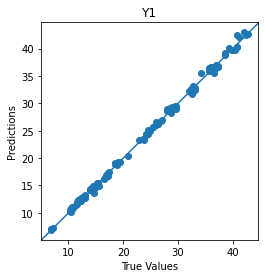

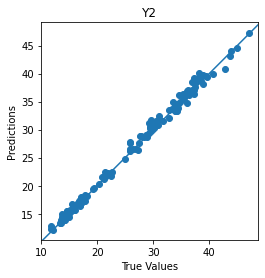

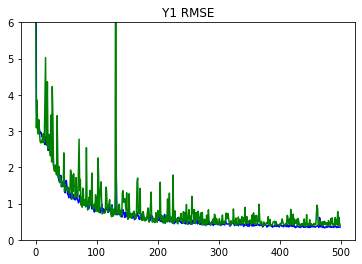

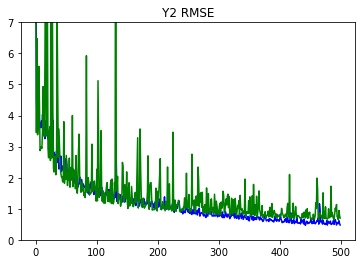

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)